<center><font size="40">Detecting the Fingerpint of an online community</font></center>


<H2>Table of Contents:</H2>

1. Introduction to problem
2. Description of sampling scheme
3. Summary statistics and word clouds
4. Model Construction
5. Assessing model performance


<H1>1. Introduction:</H1>

Writers leave a fingerprint in their text that can give clues to their identity, and potenentialy, their interests. This project uses Natural Language Processing, specifally BERT, to model the voice of online communities, specifially subreddits. The goal is to be able to identify indiviuals who may share the interests of those communities, but have not posted in those communities themselves. For example, not everyone who is interested in Playstation has posted in the Playstation subreddit. However, we may be able to identify such individuals by using information about the "voice" of the typical Playstation poster. 

My personal motivation for this project is driven by my interest in metal health. I wanted to determine if one could use writing samples as an indicator of depression, but a dataset of writing samples from individuals with and without depression does not currently exist. Online forums, however, provide a potential source of writing from individuals self identified as suffering from depression. The challenge is to find an appropriately matched set of ostensibly non-depressed individuals. Due to the wide variaty of topics discussed on Reddit, it serves a promising platform from which to construct a dataset. The subbreddit "depression" consists almost entirely of individuals sharing their experiences with depression. Further, these users also post on other subreddits about topics unrelated to depression. This allows one to procure a large corpus of writing from depressed individuals, coupled with a corpus of writing by ostensibly non-depressed individuals, matched for topic. 

In [1]:
#!pip install bert-for-tf2
#!pip install sentencepiece
#!pip install tensorflow
#!pip install keras
#!pip install tensorflow_hub
#!pip install pandas
#!pip install numpy
#!pip install regex
#!pip install praw
#!pip install matplotlib
#!pip install spacy
#!pip install spacy_langdetect
#!python -m spacy download en
#!pip install pytorch_pretrained_bert
#!pip install nltk
#!pip install wordcloud
#!pip install sklearn
#!pip install ConfigParser

Loading packages and downloading resources

In [1]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
import bert
import numpy as np
import pandas as pd
import regex as re
import random
import math
import praw
import matplotlib.pyplot as plt
import spacy
from spacy_langdetect import LanguageDetector
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForNextSentencePrediction

import nltk
from nltk import WordNetLemmatizer, pos_tag, word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('wordnet')

from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import urllib3
http = urllib3.PoolManager()
profane_words_file = http.request('GET', 'https://www.cs.cmu.edu/~biglou/resources/bad-words.txt')
profane_words = set(profane_words_file.data.decode('utf-8').split('\n'))

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

from configparser import ConfigParser
import os


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/GavinLeighton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/GavinLeighton/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/GavinLeighton/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/GavinLeighton/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<H1>2. Sampling Prodecure</H1>
One obstical to identifying the voice of an online community is conflating topic with voice. One could easily differentiate a user of r/Rollerblading, for example, from the average reddit user by searching for terms like 'inline' or 'skate'. However, this analysis is after something more subtle: I want to a model that can identify a rollerblading enthusiast when they are discussing a topic completely unrelated to rollerblading. To do this I use a rigorous sampling procedure that gathers user comments in a paired fashion. For each user of a subreddit, I scrape their comments in <i>other</i> subreddits. Then, for each comment, I find a comment from a different user who has never posted in the subreddit of interest. This produces a balanced dataset that prevents topic from confounding voice.


<H3>Summary:</H3>

1. Scrape up to 1000 usernames from reddit communities of interest.
2. Scrape up to 100 comments from each user from subreddits other than the subreddit of interest.
3. For each comment, scrape a comment from the same subreddit by a user who has never posted in the subreddit of interest.


In [3]:
os.chdir('..')

parser = ConfigParser()
parser.read("reddit_scraping_config.ini")
username = parser.get('reddit_account_config', 'username')
password = parser.get('reddit_account_config', 'password')
client_secret = parser.get('reddit_account_config', 'client_secret')
user_agent = parser.get('reddit_account_config', 'user_agent')
client_id = parser.get('reddit_account_config', 'client_id')

reddit = praw.Reddit(client_id=client_id,
                     client_secret=client_secret,
                     user_agent=user_agent,
                     username=username,
                     password=password)


def get_user_comment_subreddits(user):
    user_comments_subs = set()
    try:
        print(user, end = '')
        for comment in reddit.redditor(str(user)).comments.new(limit=None):
            print(comment.subreddit)
            if comment.subreddit not in user_comments_subs:
                user_comments_subs.add(comment.subreddit)
    except:
        print(user, ' failed ', end = '')
    return user_comments_subs

def get_commenter_usernames(focal_subreddit, target_number_of_users):
    print('starting')
    usernames = set()
    for post in reddit.subreddit(focal_subreddit).comments(limit=target_number_of_users):
        if comment.author not in usernames:
            usernames.add(str(comment.author))
        if len(usernames) >= target_number_of_users:
            return usernames
    return usernames

def get_poster_usernames(focal_subreddit, target_number_of_users):
    usernames = set()
    for post in reddit.subreddit(focal_subreddit).new(limit=target_number_of_users):
        if post.author not in usernames:
            usernames.add(str(post.author))
        if len(usernames) >= target_number_of_users:
            return usernames
    return usernames

def get_comments_from_user(user_name, disallowed_subreddits, scraped_comments):
    
    user_comments = {'focal_subreddit_poster':[], 'username':[],  'corresponding_focal_username':[], 'subreddit': [], 'tokenized_text':[], 'text':[]}
   
    try:
        print('.', end = '')
        for comment in reddit.redditor(str(user)).comments.new(limit=100):
            #remove links
            comment_links_removed = re.sub(r'\d\S+', '', re.sub(r'\n', '', re.sub(r'>', '', re.sub(r'\*', '', re.sub(r'www\S+', '', re.sub(r'http\S+', '', str(comment.body)))))))
            is_english = False
            if str(nlp(comment_links_removed.lower())._.language['language']) == 'en':
                is_english = True 
            comment_formatted = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(comment_links_removed))
            if len(comment_formatted) > 10 and str(comment.subreddit).lower() not in disallowed_subreddits and is_english and str(comment_formatted[0:10]) not in scraped_comments:
                scraped_comments.add(str(comment_formatted[0:10]))
                user_comments['focal_subreddit_poster'].append(1)
                user_comments['username'].append(user_name) 
                user_comments['corresponding_focal_username'].append(user_name) 
                user_comments['subreddit'].append(str(comment.subreddit))
                user_comments['tokenized_text'].append(tuple(comment_formatted)) 
                user_comments['text'].append(comment_links_removed) 
    except:
        print(user, ' failed ', end = '')
    return user_comments, scraped_comments

def get_comment_from_subreddit(disallowed_users, sub_name, corresponding_focal_usernames, scraped_comments):
    kept_comments = 0
    target_number_of_comments = len(corresponding_focal_usernames)
    user_comments = {'focal_subreddit_poster': [], 'username':[],  'corresponding_focal_username':[], 'subreddit': [], 'tokenized_text':[], 'text':[]}
    try:
        all_comments = reddit.subreddit(sub_name).comments(limit=target_number_of_comments*1000)
        for comment in all_comments:
                if str(comment.author) not in disallowed_users:
                    comment_links_removed = re.sub(r'\d\S+', '', re.sub(r'\n', '', re.sub(r'>', '', re.sub(r'\*', '', re.sub(r'www\S+', '', re.sub(r'http\S+', '', str(comment.body)))))))
                    is_english = False
                    if str(nlp(comment_links_removed.lower())._.language['language']) == 'en':
                        is_english = True 
                    comment_formatted = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(comment_links_removed))
                    if len(comment_formatted) > 10 and is_english and str(comment_formatted[0:10]) not in scraped_comments and 'I\'m a bot' not in comment_links_removed and '^(BOT)' not in comment_links_removed and 'I am a bot' not in comment_links_removed:
                        scraped_comments.add(str(comment_links_removed[0:10]))
                        user_comments['focal_subreddit_poster'].append(0)
                        user_comments['username'].append(comment.author) 
                        user_comments['corresponding_focal_username'].append(corresponding_focal_usernames[kept_comments]) 
                        user_comments['subreddit'].append(sub_name)
                        user_comments['tokenized_text'].append(tuple(comment_formatted)) 
                        user_comments['text'].append(comment_links_removed)                       
                        kept_comments +=1
                    if kept_comments >=target_number_of_comments:
                        break
     #   print(sub_name, ' got', kept_comments, 'out of', target_number_of_comments, 'comments')
    except:
        print(sub_name, ' failed')
    return user_comments, scraped_comments

BertTokenizer = bert.bert_tokenization.FullTokenizer
hub_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"
#This url doesn't always work for me so I have downloaded the model.
bert_layer = tf.saved_model.load('bert_en_uncased_L-12_H-768_A-12_2')

vocabulary_file = bert_layer.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)
nlp = spacy.load('en')
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)



While sampling I attempt to weed out bots, which typically identify themselves, and repeated comments. As not all bots identify themselves some will inevitably remain in the dataset, but a more thorough exclusion scheme is beyond the scope of this project.

In [4]:
#1. Get users that comment in depression
#2. Count total comments in all subreddits that depression users comment in.
#3. Get an equal number of comments from each corresponding subreddits.
subreddits_of_interest = ('depression', 'depression_help')
dissallowed_subreddits = ('depression', 'depression_help', 'depression_help', 'anxietydepression', 'depressed')

#subreddits_of_interest = ('WarFrameRunway', 'Warframe')
#dissallowed_subreddits = ('WarFrameRunway', 'Warframe')

#subreddits_of_interest = ('PS4', 'PlayStation')
#dissallowed_subreddits = ('PS4', 'PS5', 'PS3', 'PS2', 'PlayStation')

scraped_comments = dict()
prev_scraped_comments = set()

target_number_of_users = 1000
usernames = set()
for sub in subreddits_of_interest:
    print('getting names from', sub)
    usernames.update(get_poster_usernames(sub, target_number_of_users))
print('collected usernames')
subreddit_comment_counts = dict()
all_user_comments = {'focal_subreddit_poster': [], 'username':[],  'corresponding_focal_username':[], 'subreddit': [], 'tokenized_text':[], 'text':[]}
other_comments = set()
if "AutoModerator" in usernames:
    usernames.remove("AutoModerator")
for user in usernames:
    curr_user_comments, prev_scraped_comments = get_comments_from_user(user, [sub.lower() for sub in dissallowed_subreddits], prev_scraped_comments)  
    if len(curr_user_comments) > 0:
        for item in curr_user_comments:
            all_user_comments[item] = all_user_comments[item] + curr_user_comments[item]
        for sub in curr_user_comments['subreddit']:
            if sub in subreddit_comment_counts:
                subreddit_comment_counts[sub].append(user)
            else:
                subreddit_comment_counts[sub] = [user]



getting names from depression
getting names from depression_help
collected usernames
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [5]:
#To ensure that I get enough high quality comments, I have to pull a lot comments from non-focal sub posters 
#per focal sub poster comment obatined above.
usernames.add('AutoModerator')
for sub in subreddit_comment_counts:
    if str(sub).lower() not in subreddits_of_interest:
        subreddit_comments, prev_scraped_comments = get_comment_from_subreddit(usernames, str(sub), subreddit_comment_counts[sub], prev_scraped_comments)
        for item in subreddit_comments:
            all_user_comments[item] = all_user_comments[item] + subreddit_comments[item]
        print('.', end = "")

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [6]:
comments_df = pd.DataFrame.from_dict(all_user_comments)
print(comments_df.size)
comments_df.head()

574176


,focal_subreddit_poster,username,corresponding_focal_username,subreddit,tokenized_text,text
0,1,justafillerusername,justafillerusername,Needafriend,"(1045, 1521, 1049, 2183, 2083, 1037, 5931, 205...",I’m going through a rough time rn too. How old...
1,1,justafillerusername,justafillerusername,friendship,"(1045, 2428, 3246, 2009, 2573, 2041, 2205, 101...",I really hope it works out too. I’ll probably ...
2,1,justafillerusername,justafillerusername,helpme,"(5094, 2500, 2428, 8509, 1037, 2868, 2006, 211...",Helping others really puts a smile on your fac...
3,1,justafillerusername,justafillerusername,helpme,"(4283, 2005, 1996, 7615, 1012, 1045, 1521, 231...",Thanks for the comment. I’ve found a couple of...
4,1,justafillerusername,justafillerusername,helpme,"(1045, 2514, 1996, 2168, 1012, 1045, 1521, 104...",I feel the same. I’m looking for new friends t...


The script sometimes fails to find a match for a comment, leading to more comments from focal subreddit posters than non-focal subreddit posters. This can occur for a variety of reasons, but it's often from individuals posting in their own subreddit with no other users. To correct this I drop any comments without a non-focal poster match.

In [7]:
for username in comments_df['corresponding_focal_username'].unique():
    num_focal  = comments_df[(comments_df['corresponding_focal_username']==username) & (comments_df['focal_subreddit_poster']==1)].shape[0]
    num_non_focal  = comments_df[(comments_df['corresponding_focal_username']==username) & (comments_df['focal_subreddit_poster']==0)].shape[0]
    if num_focal != num_non_focal:
        #print(username, num_focal, num_non_focal)
        for sub in comments_df[(comments_df['corresponding_focal_username']==username) & (comments_df['focal_subreddit_poster']==1)]['subreddit'].unique():
            num_focal = comments_df[(comments_df['corresponding_focal_username']==username) & (comments_df['focal_subreddit_poster']==1) & (comments_df['subreddit']==sub)].shape[0]
            num_non_focal = comments_df[(comments_df['corresponding_focal_username']==username) & (comments_df['focal_subreddit_poster']==0) & (comments_df['subreddit']==sub)].shape[0]
            if num_focal != num_non_focal:
               # print(username, sub, num_focal, num_non_focal)
                indexes = comments_df[(comments_df['corresponding_focal_username']==username) & (comments_df['focal_subreddit_poster']==1) & (comments_df['subreddit']==sub)].index
                comments_df.drop(index = indexes[num_non_focal:num_focal], inplace=True)


Text(0, 0.5, 'Number of comments')

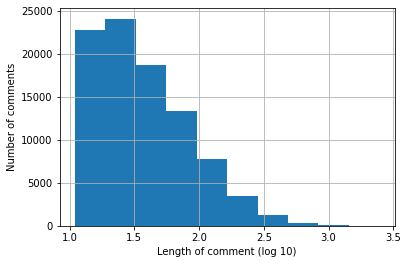

In [8]:
histplot = comments_df['tokenized_text'].str.len().transform(np.log10).hist()
histplot.set_xlabel("Length of comment (log 10)")
histplot.set_ylabel("Number of comments")

In [9]:
filename = str(subreddits_of_interest[0]) + '_comments.csv'
comments_df.to_csv(filename, index=False)


Next I prepare the comments for deriving summary statistics.

In [10]:

regex_tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
lemmatizer = nltk.stem.WordNetLemmatizer()
lem = WordNetLemmatizer()

def lemmatize_text(text):
    def lemmatize_word(word):
        pos_label = (pos_tag(word_tokenize(word))[0][1][0]).lower()
        if pos_label == 'j': 
            pos_label = 'a'  
        if pos_label in ['r']:
            return word
        elif pos_label in ['a', 's', 'v']: 
            return lem.lemmatize(word, pos=pos_label)
        else:   
            return lem.lemmatize(word)
    return ' '.join([lemmatize_word(w) for w in regex_tokenizer.tokenize(text)])

def count_profane_words(text, profane_words_list):
    count = 0
    for word in text.split(' '):
        if word in profane_words_list:
            count +=1
    return count

def get_word_length_variance(text):
    return np.var([len(word) for word in text.split(' ')])


def add_sentiment_analysis(df, column_name):
    if 'neg' in df.columns:
        df = df.drop(columns = ['neg'])
    if 'pos' in df.columns:
        df = df.drop(columns = ['pos'])
    if 'compound' in df.columns:
        df = df.drop(columns = ['compound'])
    if 'neu' in df.columns:
        df = df.drop(columns = ['neu'])
    def Analyize_sentiment_intensity(text):   
        sid = SentimentIntensityAnalyzer()
        return(sid.polarity_scores(text))
    df['sentiment_intensity'] = df[column_name].apply(Analyize_sentiment_intensity)
    return (pd.concat([df.drop(['sentiment_intensity'], axis=1), df['sentiment_intensity'].apply(pd.Series)], axis=1))

comments_df['text_links_removed'] = comments_df['text'].str.lower()
comments_df['text_lemmatized'] = comments_df.text_links_removed.apply(lemmatize_text)


dep_usernames = comments_df[comments_df['focal_subreddit_poster']==1]['username'].unique()
nondep_usernames = comments_df[comments_df['focal_subreddit_poster']==0]['username'].unique()

comments_df = add_sentiment_analysis(comments_df, 'text_lemmatized')
comments_df['mean_word_length'] = comments_df['text_lemmatized'].str.len() / comments_df['text_lemmatized'].str.split(' ').str.len()
comments_df['comment_length'] = comments_df['text_lemmatized'].str.len()
comments_df['log_comment_length'] = np.log(comments_df['comment_length'])
comments_df['profane_word_count'] = comments_df.text_lemmatized.apply(count_profane_words, profane_words_list = profane_words)
comments_df['word_count'] = comments_df['text_lemmatized'].str.split(' ').str.len()
comments_df['frac_profane_word'] = comments_df['profane_word_count'] / comments_df['word_count']



<H1>3. Summary statistics and word clouds</H1>

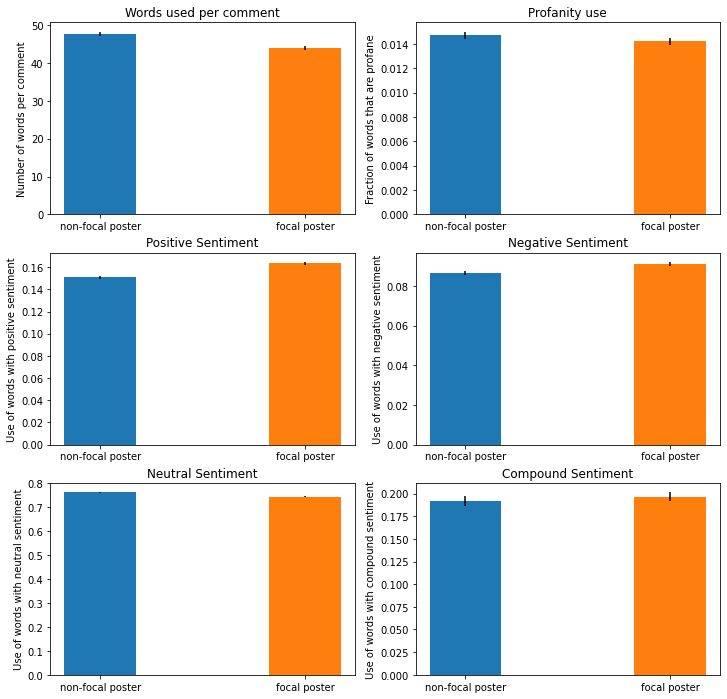

In [11]:


def plot_barchart(df, column_name, chart_title, y_label, pos, fig, ax):
    means = df.groupby(['focal_subreddit_poster'])[column_name].mean()
    conf_int = 1.96*df.groupby(['focal_subreddit_poster'])[column_name].std()/df.groupby(['focal_subreddit_poster'])[column_name].count()**0.5
    ind = np.arange(2)    # the x locations for the groups
    width = 0.35         # the width of the bars
    for conf, mean, i in zip(conf_int, means, ind):
        ax[pos].bar(i, mean, width, yerr=conf)

    ax[pos].set_title(chart_title)
    ax[pos].set_xticks(ind)
    ax[pos].set_xticklabels(('non-focal poster', 'focal poster'))
    ax[pos].set_ylabel(y_label)
    return(ax)
    
fig, axs = plt.subplots(3, 2,figsize=(12,12))

word_count_plot = plot_barchart(comments_df, 'word_count', 'Words used per comment', 'Number of words per comment', (0,0), fig, axs) 
frac_profane_word_plot = plot_barchart(comments_df, 'frac_profane_word', 'Profanity use','Fraction of words that are profane', (0,1), fig, axs) 

#word_length_var_plot = plot_barchart(comments_df, 'word_length_var', 'Variance in word length', 'Word length variance', (0,1), fig, axs) 
neg_plot = plot_barchart(comments_df, 'neg', 'Negative Sentiment', 'Use of words with negative sentiment', (1,1), fig, axs) 
pos_plot = plot_barchart(comments_df, 'pos', 'Positive Sentiment', 'Use of words with positive sentiment', (1,0), fig, axs) 
pos_plot = plot_barchart(comments_df, 'neu', 'Neutral Sentiment', 'Use of words with neutral sentiment', (2,0), fig, axs) 
pos_plot = plot_barchart(comments_df, 'compound', 'Compound Sentiment', 'Use of words with compound sentiment', (2,1), fig, axs) 



Use of profanity and sentiment analyses varies by subreddit. r/depression users show increased use of both positive an negative sentiment words, indicating generally more emotive language. Next, I proccessing comments for creating word clouds.

In [12]:
def create_word_cloud(df, column_name):
    text = df[column_name].values
    stop_words = stopwords.words('english')
    text = ' '.join(text)
    wordcloud = WordCloud(width = 800, height = 800, 
                    collocations=False,
                    background_color ='white', 
                    stopwords = stop_words, 
                    min_font_size = 10).generate(text) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 
    

vectorizer = CountVectorizer(stop_words = stopwords.words('english'))
vectorizer.fit(comments_df['text_lemmatized'])
vect_non_dep = vectorizer.transform(comments_df[comments_df['focal_subreddit_poster']==0]['text_lemmatized'])
vect_sum_non_dep = np.sum(vect_non_dep, axis = 0)

word_counts_df = pd.DataFrame(columns = ['word', 'non_focal_count'])
word_counts_df['word'] = vectorizer.get_feature_names()
word_counts_df['non_focal_count'] = np.transpose(vect_sum_non_dep)

vect_dep = vectorizer.transform(comments_df[comments_df['focal_subreddit_poster']==1]['text_lemmatized'])
vect_sum_dep = np.sum(vect_dep, axis = 0)
word_counts_df['focal_count'] = np.transpose(vect_sum_dep)

word_counts_df['focal_copy_num'] = word_counts_df['focal_count']-word_counts_df['non_focal_count']
word_counts_df['non_focal_copy_num'] = word_counts_df['non_focal_count']-word_counts_df['focal_count']
word_counts_df.loc[word_counts_df['focal_copy_num'] < 0, 'focal_copy_num'] = 0
word_counts_df.loc[word_counts_df['non_focal_copy_num'] < 0,'non_focal_copy_num'] = 0

word_counts_df['focal_str_copied'] = word_counts_df['word'] + ' '
word_counts_df['non_focal_str_copied'] = word_counts_df['word'] + ' '

word_counts_df['focal_str_copied'] = word_counts_df['focal_str_copied'].str.repeat(list(word_counts_df['focal_copy_num'].values))
word_counts_df['non_focal_str_copied'] = word_counts_df['non_focal_str_copied'].str.repeat(list(word_counts_df['non_focal_copy_num'].values))

word_counts_df['focal_str_copied'] = word_counts_df['focal_str_copied'].str.rstrip()
word_counts_df['non_focal_str_copied'] = word_counts_df['non_focal_str_copied'].str.rstrip()



<H2>Cloud of words over-represented in focal subreddit posters' comments</H2>
There are typically unique to each subreddit and can give some insight into the nature of the community.

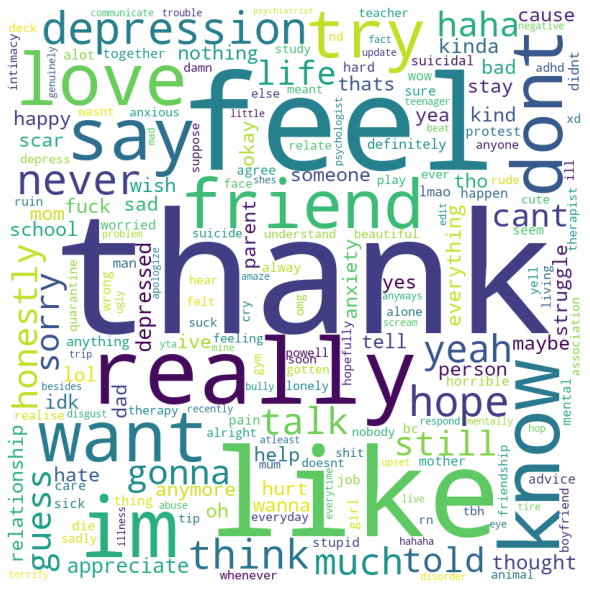

In [13]:
create_word_cloud(word_counts_df, 'focal_str_copied')


<H2>Cloud of words under-represented in focal subreddit posters' comments</H2>
This is generally less interestingering than overrepresented words, and typically consists of generally reddit accociated terms such as "post" or "submission".

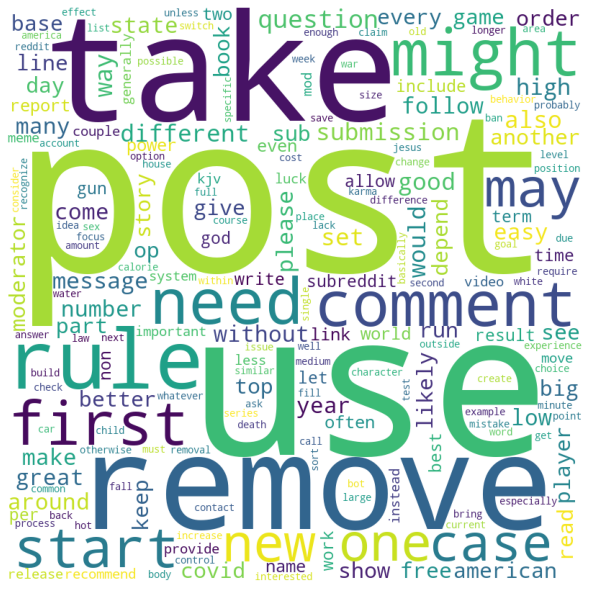

In [14]:
create_word_cloud(word_counts_df, 'non_focal_str_copied')

In [15]:
def process_dataframe_for_fitting(tokenized_text, labels):
    text_with_len = [[text, labels[i], len(tokenized_text)]
                     for i, text in enumerate(tokenized_text)]
    random.shuffle(text_with_len)
    text_with_len.sort(key=lambda x: x[2])
    sorted_text_labels = [(text_lab[0], text_lab[1]) for text_lab in text_with_len]
    processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_text_labels, output_types=(tf.int32, tf.int32))
    return processed_dataset


<H1>4. Model Construction</H1>
Here I set up my test train split. To prevent data leakage I want to make sure all comments from a focal subreddit poster are in either the test or the train split, but not both. I could do the same for the comments from the non-focal subreddit users, but I'm not going to for two reasons. First, there are many more non-focal subreddit users than focal users, and most are associated with a single focal subreddit user, so the degree of data leakage should be minimal. Second, it would sacrifice the paired-by-topic nature of the dataset, which may cause to model to fit more on topic than writing style.

In [16]:

dep_usernames = comments_df[comments_df['focal_subreddit_poster']==1]['username'].unique()
random.shuffle(list(dep_usernames))
split_frac = 0.75
test_usernames = list(dep_usernames[:int(len(dep_usernames)*split_frac)]) 
train_usernames = list(dep_usernames[int(len(dep_usernames)*(1-split_frac)):])

comments_df_test = comments_df[comments_df['corresponding_focal_username'].isin(test_usernames)]
comments_df_train = comments_df[comments_df['corresponding_focal_username'].isin(train_usernames)]


In [17]:
BATCH_SIZE = 32
batched_test_dataset = process_dataframe_for_fitting(comments_df_test['tokenized_text'].values, comments_df_test['focal_subreddit_poster'].values).padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))
batched_train_dataset = process_dataframe_for_fitting(comments_df_train['tokenized_text'].values, comments_df_train['focal_subreddit_poster'].values).padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))
input_array_length = next(iter(batched_train_dataset))[0][0].shape[0]

TOTAL_BATCHES = math.ceil(comments_df_train.size / BATCH_SIZE)
TEST_BATCHES = TOTAL_BATCHES // 10
test_data = batched_test_dataset
train_data = batched_train_dataset

Below is the model. I started with the model in this link from [Usman Malik](https://stackabuse.com/text-classification-with-bert-tokenizer-and-tf-2-0-in-python/), and tweaked the parameters to prevent overfitting.

In [18]:
class TEXT_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions,
                                         trainable = False)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu",
                                        trainable = False)
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu",
                                        trainable = False)
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")#,
                                        #trainable = False)
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.last_dense = layers.Dense(units=1, activation="sigmoid")

    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) 
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 200
CNN_FILTERS = 100
DNN_UNITS = 256
OUTPUT_CLASSES = 2
DROPOUT_RATE = 0.3
NB_EPOCHS = 5


In [19]:
text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=OUTPUT_CLASSES,
                        dropout_rate=DROPOUT_RATE,
                       )

In [20]:
text_model.compile(loss="binary_crossentropy",
                       optimizer="rmsprop",
                       metrics=["accuracy"])

In [21]:
#I've tested this script on several subreddit and found that 5-6 epochs seems to provide the best accuracy without too much overfitting.
text_model.fit(train_data, epochs=6)


Epoch 1/6
2112/2112 [==============================] - 188s 89ms/step - loss: 0.6832 - accuracy: 0.5544
Epoch 2/6
2112/2112 [==============================] - 187s 89ms/step - loss: 0.6676 - accuracy: 0.5885
Epoch 3/6
2112/2112 [==============================] - 187s 89ms/step - loss: 0.6386 - accuracy: 0.6306
Epoch 4/6
2112/2112 [==============================] - 189s 90ms/step - loss: 0.5879 - accuracy: 0.6877
Epoch 5/6
2112/2112 [==============================] - 188s 89ms/step - loss: 0.5305 - accuracy: 0.7357
Epoch 6/6
2112/2112 [==============================] - 188s 89ms/step - loss: 0.4742 - accuracy: 0.7764


<H1>5. Assessing model performance</H1>
The predictive power of the model using comments determined using the test set of comments. Accuracy is usually from 70% to 80% depending on the subreddit. 

In [22]:
results = text_model.evaluate(test_data)


2203/2203 [==============================] - 109s 50ms/step - loss: 0.5815 - accuracy: 0.7224


Next I'll look at the predictions in a little more detail.

In [23]:
def process_dataframe_for_predicting(tokenized_text, labels):
    text_with_len = [[text, labels[i], len(tokenized_text)]
                     for i, text in enumerate(tokenized_text)]
    sorted_text_labels = [(text_lab[0], text_lab[1]) for text_lab in text_with_len]
    processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_text_labels, output_types=(tf.int32, tf.int32))
    return processed_dataset

In [24]:
new_df = comments_df_test.copy()

pred_data = process_dataframe_for_predicting(comments_df_test['tokenized_text'].values, comments_df_test['focal_subreddit_poster'].values).padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

new_df['predicted'] = text_model.predict(pred_data)


The comments that are most highly predicted to be from posters in the focal subreddit can be illuminating. Unfortunately the reverse is typically not true as comments predicted to be least likely from posters in the focal subreddit are mostly bots.

In [30]:
new_df.sort_values(by = ['predicted'], ascending=True).head()

,focal_subreddit_poster,username,corresponding_focal_username,subreddit,tokenized_text,text,text_links_removed,text_lemmatized,neg,neu,pos,compound,mean_word_length,comment_length,log_comment_length,profane_word_count,word_count,frac_profane_word,predicted,pred_binary
53515,0,ModeratelyHelpfulBot,Facu5230,memes,"(7632, 1010, 4283, 2005, 2108, 2112, 1997, 203...","Hi, thanks for being part of memes! Unfortunat...","hi, thanks for being part of memes! unfortunat...",hi thanks for be part of meme unfortunately yo...,0.050,0.829,0.122,0.7501,5.255102,515,6.244167,1,98,0.010204,5.669608e-09,0
53506,0,ModeratelyHelpfulBot,averageghosthuman,memes,"(7632, 1010, 4283, 2005, 2108, 2112, 1997, 203...","Hi, thanks for being part of memes! Unfortunat...","hi, thanks for being part of memes! unfortunat...",hi thanks for be part of meme unfortunately yo...,0.050,0.857,0.093,0.5106,5.292929,524,6.261492,1,99,0.010101,6.141965e-09,0
79663,0,ModeratelyHelpfulBot,PikaGirl41114,DirtySnapchat,"(7592, 1010, 2017, 2031, 3130, 6866, 1015, 123...","Hello, you have previously posted 1 submission...","hello, you have previously posted 1 submission...",hello you have previously post 1 submission to...,0.029,0.860,0.111,0.7003,5.402299,470,6.152733,0,87,0.000000,8.952611e-09,0
79662,0,ModeratelyHelpfulBot,PikaGirl41114,DirtySnapchat,"(7592, 1010, 2017, 2031, 3130, 6866, 1015, 123...","Hello, you have previously posted 1 submission...","hello, you have previously posted 1 submission...",hello you have previously post 1 submission to...,0.054,0.843,0.103,0.5267,5.304348,488,6.190315,0,92,0.000000,1.212400e-08,0
53454,0,ModeratelyHelpfulBot,sigurdrp,memes,"(7632, 1010, 4283, 2005, 2108, 2112, 1997, 203...","Hi, thanks for being part of memes! Unfortunat...","hi, thanks for being part of memes! unfortunat...",hi thanks for be part of meme unfortunately yo...,0.050,0.859,0.092,0.5106,5.196078,530,6.272877,1,102,0.009804,2.176353e-08,0


Next I'll look at the confusion matrix to see how well the model detects positives and negatives.

In [26]:
new_df['pred_binary'] = 0
new_df.loc[new_df['predicted']>0.5,['pred_binary']]=1
accuracy = dict()
step = 1
for i in range(0, 10, step):

    df_slice  = new_df[(new_df['predicted']*10>i) & (new_df['predicted']*10 < i+step)]
    if df_slice.shape[0] > 0:
        accuracy[i] = 1 - np.array([abs(df_slice['pred_binary']-df_slice['focal_subreddit_poster'])]).mean()

tf.math.confusion_matrix(
    new_df['focal_subreddit_poster'], new_df['pred_binary'], num_classes=None, weights=None, dtype=tf.dtypes.int32,
    name=None
)

print('True positive rate:', round(new_df[(new_df['focal_subreddit_poster']==1) &  (new_df['pred_binary']==1) ].shape[0] / new_df.shape[0], 2))
print('False negative rate:', round(new_df[(new_df['focal_subreddit_poster']==1) &  (new_df['pred_binary']==0) ].shape[0]/ new_df.shape[0], 2))
print('True negative rate:', round(new_df[(new_df['focal_subreddit_poster']==0) &  (new_df['pred_binary']==0) ].shape[0]/ new_df.shape[0], 2))
print('False positive rate:', round(new_df[(new_df['focal_subreddit_poster']==0) &  (new_df['pred_binary']==1) ].shape[0]/ new_df.shape[0], 2))



True positive rate: 0.42
False negative rate: 0.08
True negative rate: 0.3
False positive rate: 0.2


Typically the model is roughly as good at detecting true negative as detecting true positives. Next I want to see how well the predicted probability of being from a poster in a focal subreddit aligns with the accuracy; i.e. is a comment with probability 0.9 more likely to be from a focal subreddit poster than a comment with probability 0.7?

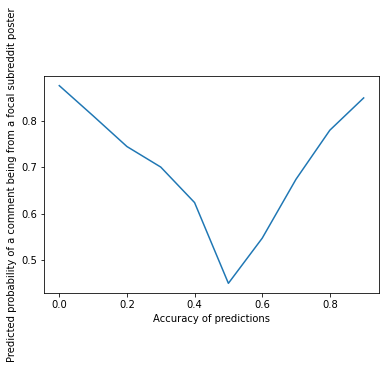

In [27]:
accuracy_df = pd.DataFrame.from_dict(accuracy,  orient='index', columns = ['accuracy'])
x = accuracy_df.index /10
y = accuracy_df['accuracy']

plt.plot(x, y)
plt.xlabel("Accuracy of predictions")
plt.ylabel("Predicted probability of a comment being from a focal subreddit poster")
plt.show()


It looks like the probabilites correspond fairly well to the accuracy. Further the predictions are highly bimodal, suggesting that the model is confident in its predictions of most comments. That is somewhat surprising because many of the comments are fairly short and I would assume have little information in them.

Text(0, 0.5, 'Number of comments')

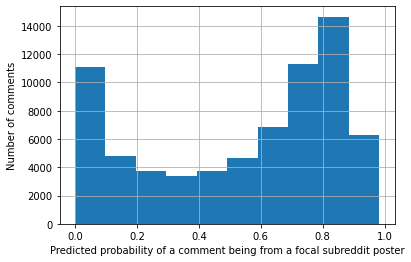

In [28]:
histplot = new_df['predicted'].hist()
histplot.set_xlabel("Predicted probability of a comment being from a focal subreddit poster")
histplot.set_ylabel("Number of comments")